In [227]:
import numpy as np
import pandas as pd
import os
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from keras import backend as K
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

import pickle
import tabulate

In [2]:
N_FRAMES = 128
INPUT_DIM = (128, 128, 1)
TRAINED_MODEL_PATH = 'trained_models/Siamese_FirstTrack_128x128/Siamese_FirstTrack_128x128.model'
HISTORY_PATH = 'trained_models/Siamese_FirstTrack_128x128/history.pickle'
FEATURE_DIR = '../data/features/mel_spec_first/'

In [3]:
# Load trained model
model = load_model(TRAINED_MODEL_PATH)
# Load training history
history = pickle.load(open(HISTORY_PATH, 'r'))

/Users/harryxue/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


# Plot training history

In [ ]:
pd.Series(history['val_acc']).plot()
pd.Series(history['acc']).plot()

In [ ]:
pd.Series(history['val_loss']).plot()
pd.Series(history['loss']).plot()

In [15]:
influences = pd.read_csv('../data/allmusic/influences_cleaned.csv')
artists = pd.read_csv('../data/allmusic/artists_cleaned.csv')
song_release_df = pd.read_csv('../data/artist_song_list_years_cleaned.csv')

# Create lookup dictionary mapping file id to artist id
file2id = {}

for filename in os.listdir(FEATURE_DIR):
    file2id[filename] = int(filename.split('.npy')[0]) 

id2file = {id:filename for (filename, id) in file2id.items()}

In [5]:
# Load validation relationship pairs
pos_val_rel, neg_val_rel = np.load('relationships/pos_val_rel.npy'), np.load('relationships/neg_val_rel.npy')

In [81]:
def sample_frames(melspec, n_frames):
    """Sample n_frames (contiguous) from a melspec representation"""
    total_frames = melspec.shape[1]
    sample_range = range(0, total_frames - n_frames + 1)
    sample_index = random.choice(sample_range)
    
    return melspec[:, sample_index:sample_index + n_frames]

In [7]:
def predict_val(pos_ex, neg_ex, model=model, n_frames=N_FRAMES):
    # Create binary labels for examples
    labels = np.concatenate((np.ones(len(pos_ex)), np.zeros(len(neg_ex))))
    all_ex = list(zip(np.concatenate((pos_ex, neg_ex)), labels))
    examples, labels = zip(*all_ex)
    
    Y_pred, Y_actual = [], []
    
    random.shuffle(all_ex)
    examples, labels = zip(*all_ex)

    for example, label in tqdm_notebook(zip(examples, labels)):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
        pred = model.predict([pair_first[np.newaxis, :, :,np.newaxis], pair_second[np.newaxis, :, :, np.newaxis]])
        Y_pred.append(pred[0][0])
        Y_actual.append(label)
        
    return Y_pred, Y_actual, examples

In [8]:
Y_pred, Y_actual, id_pairs = predict_val(pos_val_rel, neg_val_rel)

A Jupyter Widget

In [12]:
# Save val predictions since prediction takes long time
pickle.dump(Y_pred, open('val_pred/Y_pred.npy', 'wb'))
pickle.dump(Y_actual, open('val_pred/Y_actual.npy', 'wb'))
pickle.dump(id_pairs, open('val_pred/id_pairs.npy', 'wb'))

In [6]:
# Load val predictions
Y_pred = pickle.load(open('val_pred/Y_pred.npy', 'rb'))
Y_actual = pickle.load(open('val_pred/Y_actual.npy', 'rb'))
id_pairs = pickle.load(open('val_pred/id_pairs.npy', 'rb'))

# Precision, Recall, F-Score

In [13]:
accuracy_score(Y_actual, np.array(Y_pred) > 0.5)

0.7049833438372197

In [14]:
precision_score(Y_actual, np.array(Y_pred) > 0.5)

0.6925125776857058

In [15]:
recall_score(Y_actual, np.array(Y_pred) > 0.5)

0.7373728279463402

In [16]:
f1_score(Y_actual, np.array(Y_pred) > 0.5)

0.7142389953561384

# Accuracy for Same Genre Pairs v. Different Genre Pairs

In [153]:
# Create df for tracking whether genres are the same or not
genre_same_df = pd.DataFrame({'Y_actual': Y_actual, 'Y_pred': (pd.Series(Y_pred) > 0.5).apply(float), 'Y_pred_raw': Y_pred, 'id_pair': id_pairs})

In [154]:
# Add column for whether genre is the same
genre_same_df['same_genre'] = genre_same_df['id_pair'].map(lambda x: artists[artists['id'] == x[0]]['main_genre'].iloc[0] == artists[artists['id'] == x[1]]['main_genre'].iloc[0])

In [155]:
# Add shared genre label if genre is the same
genre_same_df['shared_genre'] = genre_same_df['id_pair'].map(lambda x: artists[artists['id'] == x[0]]['main_genre'].iloc[0] if artists[artists['id'] == x[0]]['main_genre'].iloc[0] == artists[artists['id'] == x[1]]['main_genre'].iloc[0] else None)

In [156]:
# Calculate accuracy, precision, recall, F1 score
# for same genre pairs v. different pairs
print genre_same_df.groupby('same_genre').apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: precision_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: recall_score(x['Y_actual'], x['Y_pred']))
print genre_same_df.groupby('same_genre').apply(lambda x: f1_score(x['Y_actual'], x['Y_pred']))

same_genre
False    0.697102
True     0.713427
dtype: float64
same_genre
False    0.419786
True     0.848382
dtype: float64
same_genre
False    0.647133
True     0.767645
dtype: float64
same_genre
False    0.509237
True     0.805997
dtype: float64


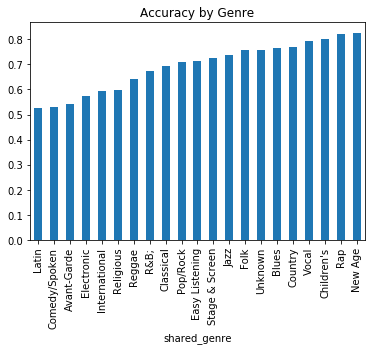

In [157]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Accuracy by Genre')

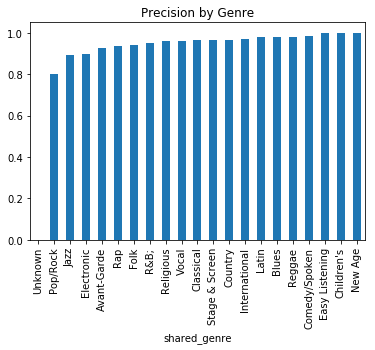

In [158]:
# Accuracy, precision, recall by genre for subset where genre is the same
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: precision_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Precision by Genre')

### Accuracy, precision, recall by genre for subset where genre is the same

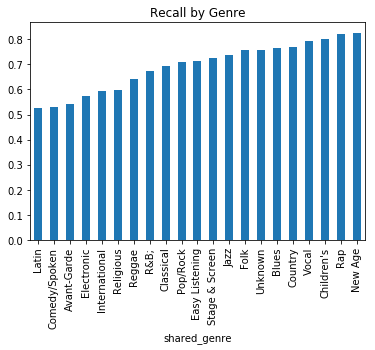

In [159]:
genre_same_df[genre_same_df['same_genre'] == True].groupby('shared_genre')\
                                                .apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))\
                                                .sort_values()\
                                                .plot('bar', title='Recall by Genre')

# Accuracy by number of years between samples

In [160]:
def get_year_by_id(id, song_release_df=song_release_df):
    '''Based on id of artist, get year of release for first song by that artist'''
    try:
        year = song_release_df[(song_release_df['artist_id'] == id)]['year'].iloc[0]
        if year == 0.:
            return float('inf')
        return year
    except:
        return float('inf')

In [161]:
# Add column for number of years between two songs in a pair
genre_same_df['years_between'] = genre_same_df['id_pair'].apply(lambda x: abs(get_year_by_id(x[0]) - get_year_by_id(x[1])))
# Convert inf values to NaN
genre_same_df['years_between'] = genre_same_df['years_between'].replace([np.inf], np.nan)

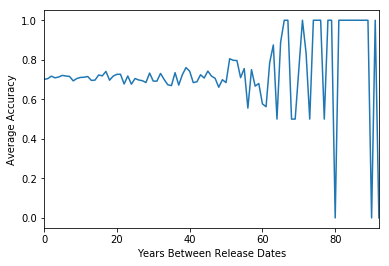

In [226]:
# Compute average accuracy by years between samples
genre_same_df[genre_same_df['years_between'].notnull()].groupby('years_between')\
                                                .apply(lambda x: accuracy_score(x['Y_actual'], x['Y_pred']))\
                                                .plot()
plt.xlabel('Years Between Release Dates')
plt.ylabel('Average Accuracy')

In [152]:
years_df = genre_same_df[genre_same_df['years_between'].notnull()][['Y_actual', 'Y_pred', 'years_between']]
# Add column for whether prediction is correct
years_df['correct_pred'] = years_df['Y_actual'] == years_df['Y_pred']
# Export to csv for statistical analysis in R
years_df.to_csv('true_pred_by_year.csv', index=False, )

# Baseline: Accuracy for Samples From Same Song

In [86]:
# Create "pairs" of the same id repeated to use as baseline
unique_val_ids = np.unique(np.append(neg_val_rel.flatten(), pos_val_rel.flatten()))
same_id_pairs = np.array([[id, id] for id in unique_val_ids])

In [ ]:
def predict_val_same_song(same_id_pairs, model=model, n_frames=N_FRAMES):
    # Create binary labels for examples
    labels = np.ones(len(same_id_pairs))
    all_ex = list(zip(same_id_pairs, labels))
    examples, labels = zip(*all_ex)
    
    Y_pred, Y_actual = [], []
    
    random.shuffle(all_ex)
    examples, labels = zip(*all_ex)

    for example, label in tqdm_notebook(zip(examples, labels)):
        # Extract sample of size N_FRAMES from mel_spec representation
        # for each example in pair
        pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
        pred = model.predict([pair_first[np.newaxis, :, :,np.newaxis], pair_second[np.newaxis, :, :, np.newaxis]])
        Y_pred.append(pred[0][0])
        Y_actual.append(label)
        
    return Y_pred, Y_actual, examples

In [ ]:
Y_pred_same, Y_actual_same, id_pairs_shuffled = predict_val_same_song(same_id_pairs)

In [ ]:
accuracy_score(Y_actual_same, np.array(Y_pred_same) > 0.5)

# Error Analysis: Most confident predictions that were wrong

In [203]:
def id_to_artist_song(id, song_release_df=song_release_df):
    '''Lookup artist name and songname by id'''
    try:
        song = song_release_df[(song_release_df['artist_id'] == id)]['song_name'].iloc[0]
        artist = song_release_df[(song_release_df['artist_id'] == id)]['artist_name'].iloc[0]
    
        return artist + ' - ' + song
    except:
        return 'Not found'

In [204]:
false_pos_df = genre_same_df[(genre_same_df['Y_actual'] != genre_same_df['Y_pred']) & (genre_same_df['Y_pred_raw'] > 0.95)]
false_pos_df['names'] = false_pos_df['id_pair'].apply(lambda x: id_to_artist_song(x[0]) + ', ' + id_to_artist_song(x[1]))
false_pos_df = false_pos_df.sort_values('Y_pred_raw', ascending=False)

/Users/harryxue/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [228]:
false_pos_df

,Y_actual,Y_pred,Y_pred_raw,id_pair,same_genre,shared_genre,years_between,names
17019,0.0,1.0,0.985368,"[515755, 357406]",True,Pop/Rock,19.0,"Brainiac - Hot Seat Can't Sit Down, Nirvana - ..."
7872,0.0,1.0,0.976721,"[629564, 216318]",True,Pop/Rock,4.0,"Buzzcocks - Fast Cars, Xasthur - Trauma Will A..."
26724,0.0,1.0,0.976054,"[63763, 490004]",True,Pop/Rock,11.0,"Babyland - Past Lives, Ramones - Gimme Gimme S..."
25392,0.0,1.0,0.973814,"[7040, 98465]",True,Pop/Rock,14.0,"Tony Iommi - Paranoid, Iron Maiden - Powerslave"
25978,0.0,1.0,0.973143,"[351733, 78836]",True,Pop/Rock,4.0,"Nine Inch Nails - The Hand That Feeds, Badland..."
1219,0.0,1.0,0.972291,"[954761, 379125]",True,Pop/Rock,11.0,"Winter - Winter, Neil Young - The Needle and t..."
15380,0.0,1.0,0.970423,"[133719, 34988]",False,None,2.0,"Fatboy Slim - Right Here Right Now, Swans - I ..."
1324,0.0,1.0,0.965690,"[354105, 151431]",False,None,2.0,"Jimi Hendrix - Machine Gun, Roger Miller - Old..."
19394,0.0,1.0,0.965610,"[357406, 950956]",True,Pop/Rock,23.0,"Nirvana - Been a Son, Gorilla Biscuits - New D..."
3713,0.0,1.0,0.961905,"[490004, 693101]",False,None,18.0,"Ramones - Gimme Gimme Shock Treatment, Yves De..."


In [235]:
print tabulate.tabulate(false_pos_df[['names', 'Y_pred_raw']], headers=['Input Pair', 'Predicted Probability'], tablefmt='latex', showindex=False)

\begin{tabular}{lr}
\hline
 Input Pair                                                             &   Predicted Probability \\
\hline
 Brainiac - Hot Seat Can't Sit Down, Nirvana - Been a Son               &                0.985368 \\
 Buzzcocks - Fast Cars, Xasthur - Trauma Will Always Linger             &                0.976721 \\
 Babyland - Past Lives, Ramones - Gimme Gimme Shock Treatment           &                0.976054 \\
 Tony Iommi - Paranoid, Iron Maiden - Powerslave                        &                0.973814 \\
 Nine Inch Nails - The Hand That Feeds, Badlands - Ride the Jack        &                0.973143 \\
 Winter - Winter, Neil Young - The Needle and the Damage Done           &                0.972291 \\
 Fatboy Slim - Right Here Right Now, Swans - I Am the Sun               &                0.970423 \\
 Jimi Hendrix - Machine Gun, Roger Miller - Old Friends                 &                0.96569  \\
 Nirvana - Been a Son, Gorilla Biscuits - New Direction  

# Rank Influences for a Given Artist

In [249]:
# Load influence relationships
influences = pd.read_csv('../data/allmusic/influences_cleaned.csv')

In [340]:
def compute_influence_proportions(artist_id, influences=influences, num_samples=100, model=model, n_frames=N_FRAMES):
    '''For a given artist, use the trained siamese model to predict
    percentage influence from each of the artists' influences
    '''
    # Get list of all the artist's influences' ids
    influences_ids = influences[influences['follower_id'] == artist_id]['influencer_id'].tolist()
    
    print 'Total influencers:', len(influences_ids)
    
    # Initialize (num_influences, num_samples) array of predicted influence probabilities
    pred_inf_matrix = np.zeros((len(influences_ids), num_samples))
    
    # Fill in predicted influence probabilities matrix
    for i, influence_id in tqdm_notebook(enumerate(influences_ids)):
        example = [artist_id, influence_id]
        
        for j in range(num_samples):
            pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
            pred = model.predict([pair_first[np.newaxis, :, :,np.newaxis], pair_second[np.newaxis, :, :, np.newaxis]])
            pred_inf_matrix[i][j] = pred[0][0]
    
    # Calculate mean across samples and normalize to get probability vector
    mean_infs = pred_inf_matrix.mean(axis=1)
    probs = mean_infs / mean_infs.sum()
    
    # Create dataframe with influence id, influence name, probabilities as columns
    influence_prob_df = pd.DataFrame({'proportion_influence': probs})
    influence_prob_df['influencer_name'] = pd.Series(influences_ids).apply(lambda x: artists[artists['id'] == x]['name'].iloc[0])
    
    return influence_prob_df.sort_values('proportion_influence', ascending=False)


In [341]:
charlie_parker_prop = compute_influence_proportions(211758)
charlie_parker_prop

Total influencers: 16


A Jupyter Widget

,proportion_influence,influencer_name
12,0.067838,Louis Armstrong
6,0.066490,Ben Webster
2,0.066285,Coleman Hawkins
13,0.066081,Roy Eldridge
3,0.063592,Buster Smith
7,0.062944,Benny Carter
5,0.062733,Lester Young
15,0.062463,Barney Kessel
1,0.062417,Erskine Hawkins
0,0.062049,Art Tatum


In [320]:
j_cole_prop = compute_influence_proportions(1089515)
j_cole_prop

Total influencers: 9


A Jupyter Widget

,proportion_influence,influencer_name
1,0.124236,2Pac
5,0.124146,Pharrell Williams
3,0.124084,Jay-Z
2,0.122706,Nas
7,0.116895,Clipse
4,0.108001,OutKast
6,0.101246,Eric B. & Rakim
0,0.090342,Pete Rock
8,0.088345,Murs


In [328]:
print tabulate.tabulate(j_cole_prop[j_cole_prop.columns[::-1]], headers=['Influencer Name', 'Estimated Influence Proportion'], tablefmt='latex', showindex=False)

\begin{tabular}{lr}
\hline
 Influencer Name   &   Estimated Influence Proportion \\
\hline
 2Pac              &                        0.124236  \\
 Pharrell Williams &                        0.124146  \\
 Jay-Z             &                        0.124084  \\
 Nas               &                        0.122706  \\
 Clipse            &                        0.116895  \\
 OutKast           &                        0.108001  \\
 Eric B. \& Rakim   &                        0.101246  \\
 Pete Rock         &                        0.0903422 \\
 Murs              &                        0.0883447 \\
\hline
\end{tabular}


In [329]:
print tabulate.tabulate(charlie_parker_prop[charlie_parker_prop.columns[::-1]], headers=['Influencer Name', 'Estimated Influence Proportion'], tablefmt='latex', showindex=False)

\begin{tabular}{lr}
\hline
 Influencer Name   &   Estimated Influence Proportion \\
\hline
 Roy Eldridge      &                        0.0669437 \\
 Louis Armstrong   &                        0.0664712 \\
 Ben Webster       &                        0.0659504 \\
 Coleman Hawkins   &                        0.0641175 \\
 Benny Carter      &                        0.0634215 \\
 Barney Kessel     &                        0.0631203 \\
 Buster Smith      &                        0.0627861 \\
 Lester Young      &                        0.0623917 \\
 Art Tatum         &                        0.0620452 \\
 Erskine Hawkins   &                        0.0619891 \\
 Johnny Hodges     &                        0.0617768 \\
 Don Byas          &                        0.0614892 \\
 Illinois Jacquet  &                        0.0609022 \\
 Count Basie       &                        0.0594951 \\
 Jay McShann       &                        0.059046  \\
 Jimmy Dorsey      &                        0.058054  

In [342]:
influences[influences['follower_name'] == 'Dizzy Gillespie']

,influencer_name,influencer_url,follower_name,follower_url,influencer_id,follower_id
27130,Fats Waller,https://www.allmusic.com/artist/fats-waller-mn...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,162762,162677
33910,Louis Armstrong,https://www.allmusic.com/artist/louis-armstron...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,234518,162677
42170,Sidney Bechet,https://www.allmusic.com/artist/sidney-bechet-...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,33234,162677
43738,Charlie Shavers,https://www.allmusic.com/artist/charlie-shaver...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,179732,162677
43739,"Henry ""Red"" Allen",https://www.allmusic.com/artist/henry-red-alle...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,675395,162677
43740,Roy Eldridge,https://www.allmusic.com/artist/roy-eldridge-m...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,346637,162677
43741,Billy Eckstine,https://www.allmusic.com/artist/billy-eckstine...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,82584,162677
43742,Bix Beiderbecke,https://www.allmusic.com/artist/bix-beiderbeck...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,104461,162677
43743,Lionel Hampton,https://www.allmusic.com/artist/lionel-hampton...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,833150,162677
43744,Coleman Hawkins,https://www.allmusic.com/artist/coleman-hawkin...,Dizzy Gillespie,https://www.allmusic.com/artist/dizzy-gillespi...,776363,162677


# Visualize Embeddings for Each Artist's First Track

In [78]:
# Use weights from trained model to build a truncated embedding model to get
# fixed size embedding for each sample
input_shape = INPUT_DIM
left_input = Input(input_shape)
right_input = Input(input_shape)

embedding_model = Sequential()
embedding_model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape, kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[0], model.layers[2].get_weights()[1]]))
embedding_model.add(MaxPooling2D()) 
embedding_model.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[2], model.layers[2].get_weights()[3]]))
embedding_model.add(MaxPooling2D())
embedding_model.add(Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[4], model.layers[2].get_weights()[5]]))
embedding_model.add(MaxPooling2D())
embedding_model.add(Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(2e-4), weights=[model.layers[2].get_weights()[6], model.layers[2].get_weights()[7]]))
embedding_model.add(Flatten())
embedding_model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3), weights=[model.layers[2].get_weights()[8], model.layers[2].get_weights()[9]]))

In [84]:
def siamese_embed(ids, embedding_model=embedding_model, n_frames=N_FRAMES):
    """Generate fixed size embeddings for samples using the trained Siamese network"""
    preds = []
    
    for id in tqdm_notebook(ids):
        # Extract sample of size N_FRAMES from mel_spec representation
        sample = sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) 
        pred = embedding_model.predict([sample[np.newaxis, :, :,np.newaxis]])[0]
        preds.append(pred)
    
    return preds

In [90]:
ids = id2file.keys()
siamese_embeddings = siamese_embed(ids)

A Jupyter Widget

In [ ]:
# Top 7 most popular genres, removing 'Unknown'
top_genres = artists['main_genre'].value_counts()[:8].index.tolist()
top_genres.remove('Unknown')

In [ ]:
# Filter for ids of artists with > 25 followers
ids_filtered = artists[(artists['main_genre'].isin(top_genres))]['id'].tolist()

In [ ]:
# Create feature matrix
X = []
ids = []
# Create lists of artist name and main genre for visualization purposes
artist_names = []
main_genres = []

for id in ids_filtered:
    try:
        X.append(embed_dict[id].flatten())
        ids.append(id)
        main_genres.append(artists[artists['id'] == id]['main_genre'].iloc[0])
        artist_names.append(artists[artists['id'] == id]['name'].iloc[0])

    # we don't have audio for some ids, so pass
    except Exception as e:
        pass

X = np.array(X)

In [ ]:
# Scale to 0 mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
# Reduce dimensionality of X
X_reduced = pca.transform(X_scaled)

In [ ]:
# Percentage of variance explained
pca.explained_variance_ratio_

In [ ]:
pca_df = pd.DataFrame(dict(x=X_reduced[:,0], y=X_reduced[:,1], genre=main_genres, name=artist_names))
sns.lmplot('x', 'y', data=pca_df, hue='genre', fit_reg=False, scatter_kws={'alpha':0.5})
plt.title('First 2 Principle Components of Siamese Embeddings')